
















# Import Packages

In [1]:
import numpy as np
import math
import time
from LBL_funcs_shortwave import *

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# bug find:  LBL_funcs_fullSpectrum
Coeff all right.
LBL_funcs_shortwave old + LBL_funcs_fullSpectrum old, 900.
LBL_funcs_shortwave old + LBL_funcs_fullSpectrum new, 700
LBL_funcs_shortwave new + LBL_funcs_fullSpectrum new, 700


717 line  ks_all = ks_gas + ks_aer + ks_cld !!!!! its problem

In [ ]:
!python setup.py build_ext --inplace

# Define User specified input varibles

In [2]:
## general inputs
N_layer= 54 # the number of atmospheric layers
N_bundles=1000 # the number of photon bundles per wavenumber
dnu = 3# spectral resolution 0.1 is enough, 0.01 is too fine, especially for cloudy periods
nu=np.arange(2500,35000,dnu) # spectral grid on wavenumber
molecules=["H2O",'CO2','O3','N2O','CH4','O2','N2'] # considered atmospheric gases
#current trace gas surface vmr from http://cdiac.ornl.gov/pns/current_ghg.html, except O3
vmr0={"H2O":0.03,'CO2':399.5/10**6,'O3':50/10**9,'N2O':328/10**9,
          'CH4':1834/10**9,'O2':2.09/10,'N2':7.81/10}
model='AFGL midlatitude summer' #profile model, 'AFGL tropical','AFGL midlatitude summer','AFGL midlatitude winter',
#'AFGL subarctic summer','AFGL subarctic winter','AFGL US standard'
cld_model = 'default' # cloud model, 'default' or 'caseX'
period = 'day' # choose 'day' or 'night' for proper temperature profile
spectral='SW' # choose 'LW' or 'SW'
alt = 0 # altitude of location, by default is 0

##inputs for desired atmoshperic and surface conditions
#surface_v=['case2','PV','CSP'] # name of surface
surface_v=['case2'] # name of surface
rh0_v=np.array([20])/100 # surface relative humidity
T_surf_v=np.array([294])#np.arange(294.2,295,5) # surface temperature
AOD_v=np.array([0.2]) # aerosol optical depth at 479.5 nm
COD_v=np.array([0]) # cloud optical depth at 479.5 nm
#CODs=np.array([0,0.1,0.3,0.5,0.7,1.0,3.0,5.0,10.0,50.0]) # cloud optical depth at 479.5 nm
kap_v=[[10,11,12]]
#kap_v=[[10],[8,9,10],[6,7,8,9,10],[4,5,6,7,8,9,10],
#      [22],[19,20,21,22],[16,17,18,19,20,21,22],[13,14,15,16,17,18,19,20,21,22],
#      [10,11,12,13,14,15,16,17,18,19,20,21,22],[7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],
#      [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]] # cloud residancy layer

##inputs of angles
#th0_v = np.array([0,15,30,45,60,75])
th0_v = np.array([30])#0,30,60,80])
theta0_v = th0_v / 180 * math.pi  # solar zenith angle in rad
phi0 = 0 / 180 * math.pi  #solar azimuth angle in rad
del_angle= 0.5/180*math.pi # DNI acceptance angle, in rad, default is 0.5 degree
beta_v=np.array([0])/180*math.pi # surface tilt angles in rad
phi_v=phi0+np.array([0])/180*math.pi # surface azimuth angles in rad
isTilted=False # whether to compute transposition on inclined surfaces

##inputs of finite power plant computation
x0_v=120.0*np.tan(theta0_v)*np.cos(phi0) # photon starting x location, in km
y0_v=120.0*np.tan(theta0_v)*np.sin(phi0) # photon starting y location, in km
R_pp=1 # radius of power plant in km
is_pp=False # whether to consider power plant of finite size
#dx_v=np.arange(-5.0,5.2,0.2)# displacement of input photon location
dx_v=np.array([0.0])# displacement of input photon location
## folder directory to store the results
file_dir='results_shortwave/' # create the directory first

# (optional) Save spectral optical properties of gases to local directory

In [ ]:
# get spectral absorption coefficients of gases of all layers and save to local directory
# takes a couple minutes to run, require parallel computing
# temperature dependence of kappa_a is not strong, so this cell only needed to run once for different T_surf
# need to re-run if N_layer, model, period, molecules or nu changed
from LBL_funcs_getHitran import *
N_layer = 54
molecules=["H2o",'CO2','O3','N2O','CH4','O2','N2']
p,pa=set_pressure(N_layer) 
# use a representative surface temperature of 290 K for optical properties
t,ta=set_temperature(model,p,pa, 294, period) 
inputs_kappa={'N_layer':N_layer,'model':model,'molecules':molecules,'nu':nu,
              'pa':pa,'ta':ta,'spectral':spectral}
getKappa_AllLayers(inputs_kappa)

# Run the LBL shortwave model for different atmospheric conditions

In [ ]:
# compute case by case
for iSurf in range(0,len(surface_v)):
    inputs_main={'N_layer':N_layer, 'N_bundles':N_bundles, 'nu':nu, 'molecules':molecules,'vmr0':vmr0,
       'model':model,'cld_model':cld_model,'period':period,'spectral':spectral,'surface':surface_v[iSurf], 
                 'alt':alt}
    for iRH in range(0,len(rh0_v)):
        for iT in range(0,len(T_surf_v)):
            for iAOD in range(0,len(AOD_v)):
                for iCOD in range(0,len(COD_v)):
                    for iKAP in range(0,len(kap_v)):
                        properties={'rh0':rh0_v[iRH],'T_surf':T_surf_v[iT],'AOD':AOD_v[iAOD],
                                    'COD':COD_v[iCOD],'kap':kap_v[iKAP]}
                        for iTH in range(0,len(theta0_v)):
                            angles={'theta0':theta0_v[iTH],'phi0':phi0,'del_angle':del_angle,'beta':beta_v,
                                    'phi':phi_v,'isTilted':isTilted}
                            for idx in range(0,len(dx_v)):
                                finitePP={'x0':-x0_v[iTH]+dx_v[idx],'y0':-y0_v[iTH],'R_pp':R_pp,'is_pp':is_pp}                          
                                print ("Start MonteCarlo once.")
                                start_time = time.time()
                                out1,_ = LBL_shortwave(properties,inputs_main,angles,finitePP)
                                # surf = LBL_shortwave(properties,inputs_main,angles,finitePP)
                                #coeff_gas, coeff_aer, coeff_cld, coeff_all =  LBL_shortwave(properties,inputs_main,angles,finitePP)
                                # out3 = LBL_shortwave(properties,inputs_main,angles,finitePP)
                                # rho.append(out)
                                # Den.append(densities)
                                #out = LBL_shortwave(properties,inputs_main,angles,finitePP)
                                fileName1="Results_{}_RH={}_Tsurf={}_AOD={}_COD={}".format(
                                     surface_v[iSurf],rh0_v[iRH],T_surf_v[iT],AOD_v[iAOD],COD_v[iCOD])
                                # fileName3="Coeff_{}_RH={}_Tsurf={}_AOD={}_COD={}".format(
                                #     surface_v[iSurf],rh0_v[iRH],T_surf_v[iT],AOD_v[iAOD],COD_v[iCOD])
                                #fileName2="_th0={}_dx={}.npy".format(th0_v[iTH],dx_v[idx])
                                fileName2="_th0={}_new.npy".format(th0_v[iTH])
                                #np.save(file_dir+fileName3,out3)# save results to local directory
                                #
                                #xnp.save(file_dir+fileName1+fileName2,out1)# save results to local directory
                                
                                #print ("End MonteCarlo once.")
                                end_time = time.time()
                                print ("CPU time:", end_time - start_time)

Start MonteCarlo once.
CPU time: 84.46264505386353


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [6]:
Fdw_tot=out1['F_dw']#[1,:]
Fdw_dir=out1['F_dni']/np.cos(theta0_v[iTH])
Fuw_toa=out1['F_uw']

print(np.trapz(Fdw_tot,nu))
print(np.trapz(Fdw_dir,nu)) 
print(np.trapz(Fuw_toa,nu))

929.9020580438323
867.9549691332212
219.43963918959176


### coeff debug

In [13]:
np.save('results_shortwave/coeff_aer_oldfull.npy', np.array(coeff_aer, dtype=object))
np.save('results_shortwave/coeff_cld_oldfull.npy', np.array(coeff_cld, dtype=object))
np.save('results_shortwave/coeff_gas_oldwfull.npy', np.array(coeff_gas, dtype=object))
np.save('results_shortwave/coeff_all_oldfull.npy', np.array(coeff_all, dtype=object))


NameError: name 'coeff_aer' is not defined

In [14]:
aer_o = np.load('results_shortwave/coeff_aer_oldfull.npy', allow_pickle=True)
aer_ao, aer_so, aer_go = aer_o
gas_o = np.load('results_shortwave/coeff_gas_oldwfull.npy', allow_pickle=True)
gas_ao, gas_so, gas_go = gas_o
cld_o = np.load('results_shortwave/coeff_cld_oldfull.npy', allow_pickle=True)
cld_ao, cld_so, cld_go = cld_o

In [15]:
aer_new = np.load('results_shortwave/coeff_aer_newfull.npy', allow_pickle=True)
aer_a, aer_s, aer_g, aer_f, aer_g1, aer_g2, aer_fdelM = aer_new

gas_new = np.load('results_shortwave/coeff_gas_newfull.npy', allow_pickle=True)
gas_a, gas_s, gas_g = gas_new

cld_new = np.load('results_shortwave/coeff_cld_newfull.npy', allow_pickle=True)
cld_a, cld_s, cld_g, cld_f, cld_g1, cld_g2, cld_fdelM = cld_new


1 8.470329472543003e-22


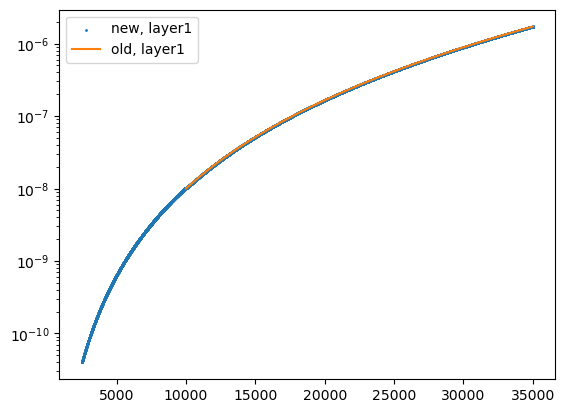

In [37]:
v1 = gas_s
v2 = gas_so
import matplotlib.pyplot as plt
for layer in range(0, 2):
    if (v1[layer]-v2[layer]).any() !=0:
        max_value = np.max(np.abs(v1[layer]-v2[layer]))
        # if max_value>1e-18:
        print(layer,max_value)
        plt.scatter(nu, v1[layer],s=1, color = "C0", label = f'new, layer{layer}')
        plt.plot(nu, v2[layer], color = "C1", label = f'old, layer{layer}')

        plt.legend()
plt.yscale('log')
plt.show()

### density debug

density same

In [7]:
np.save('results_shortwave/density_oldfull.npy', np.array(density, dtype=object))

In [4]:
np.save('results_shortwave/density_newfull.npy', np.array(density, dtype=object))

In [5]:
density_o = np.load('results_shortwave/density_oldfull.npy', allow_pickle=True)
density_new = np.load('results_shortwave/density_newfull.npy', allow_pickle=True)


In [ ]:
for mole in range(0,7):
    v1 = density_new[:,mole]
    v2 = density_o[:,mole]
    if (v1-v2).any() !=0:
        max_value = np.max(np.abs(v1-v2))
        if max_value>1e-10:
            print(mole)
            print(layer)
            print(max_value)
            

### SURF

In [4]:
np.save('results_shortwave/surf_oldfull.npy', np.array(surf, dtype=object))

In [4]:
np.save('results_shortwave/surf_newfull.npy', np.array(surf, dtype=object))

In [5]:
surf = np.load('results_shortwave/surf_newfull.npy', allow_pickle=True)
surf_o = np.load('results_shortwave/surf_oldfull.npy', allow_pickle=True)

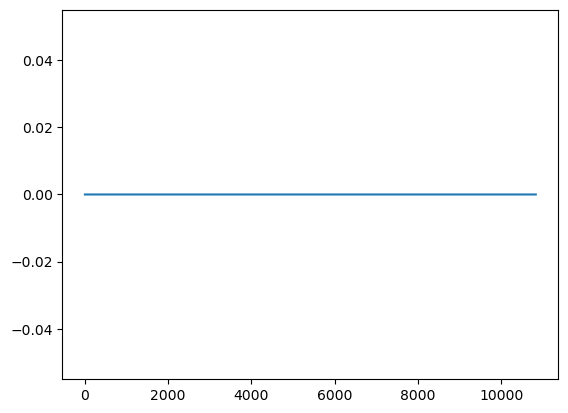

In [6]:
import matplotlib.pyplot as plt
plt.plot(surf-surf_o, label='new')
plt.show()

### new fullspecturm

In [6]:
out=np.load('results_shortwave/Results_case2_RH=0.2_Tsurf=294_AOD=0.2_COD=0_th0=30_new.npy', allow_pickle=True).item()
# quick check of the validaty of results
Fdw_tot=out['F_dw'][54,:]
Fdw_dir=out['F_dni']/np.cos(theta0_v[iTH])
Fuw_toa=out['F_uw'][-1,:]
Fuw_sur=out['F_uw'][1,:]

print(np.trapz(Fdw_tot,nu))
print(np.trapz(Fdw_dir,nu))
print(np.trapz(Fuw_toa,nu))
print(np.trapz(Fuw_sur,nu))

1164.9813838323596
648.4574615231492
166.68313516064623
155.93722596248548


### old full spectrum

In [7]:
# quick check of the validaty of results
out1 = np.load('results_shortwave/Results_case2_RH=0.2_Tsurf=294_AOD=0.2_COD=0_th0=30_old.npy', allow_pickle=True).item()
Fdw_tot=out1['F_dw'][54,:]
Fdw_dir=out1['F_dni']/np.cos(theta0_v[iTH])
Fuw_toa=out1['F_uw'][-1,:]
Fuw_sur=out1['F_uw'][1,:]

print(np.trapz(Fdw_tot,nu))
print(np.trapz(Fdw_dir,nu))
print(np.trapz(Fuw_toa,nu))
print(np.trapz(Fuw_sur,nu))

1164.9839092115321
867.5332202624397
219.186834046304
192.09383079950024


54
0.0006286958809527815
53
0.01303817768954512
52
0.02261125410123816
51
0.028425576584413692
50
0.03241925263346355
49
0.035531970730517115
48
0.03682404239344501
47
0.03858595829743759
46
0.04028914367129709
45
0.040876448972627946
44
0.04561612116958559
43
0.04883899929569761
42
0.051999898996307484
41
0.05416914388888289
40
0.05584256137744105
39
0.05739202201499491
38
0.058445655248531535
37
0.05912741792905523
36
0.059499288482068154
35
0.059685223758574615
34
0.060057094311587546
33
0.06036698643909832
32
0.06073885699211124
31
0.06073885699211124
30
0.06104874911962201
29
0.06139634439993641
28
0.062214962325268894
27
0.06259278598311466
26
0.06280671850718275
25
0.06297060964096042
24
0.06297060964096042
23
0.06297060964096042
22
0.06297060964096042
21
0.06297060964096042
20
0.06297060964096042
19
0.06297060964096042
18
0.06311241535100903
17
0.06311241535100903
16
0.06311241535100903
15
0.06311241535100903
14
0.06311241535100903
13
0.06311241535100903
12
0.06317559094195098


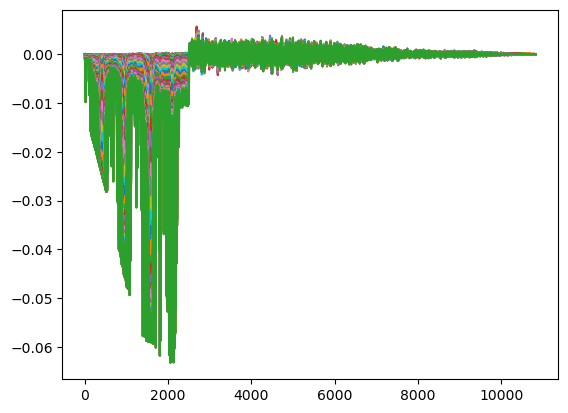

In [12]:
import matplotlib.pyplot as plt
for layer in range(54, 1,-1):
    v1 = out['F_dw'][layer,:]
    v2 = out1['F_dw'][layer,:]
    if (v1-v2).any() !=0:
        max_value = np.max(np.abs(v1-v2))
        if max_value>1e-10:
            print(layer)
            print(max_value)
            plt.plot(v1-v2)
plt.show()


In [ ]:
# quick check of the validaty of results
Fdw_tot=out['F_dw'][54,:]
Fdw_dir=out['F_dni']/np.cos(theta0_v[iTH])
Fuw_toa=out['F_uw'][-1,:]
Fuw_sur=out['F_uw'][1,:]

print(np.trapz(Fdw_tot,nu))
print(np.trapz(Fdw_dir,nu))
print(np.trapz(Fuw_toa,nu))
print(np.trapz(Fuw_sur,nu))

794.4253853356704
648.7931214717996
166.59180988252643
155.93730960949964


In [ ]:
# import sys
# import os

# # Add the parent directory to the Python path
# parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
# sys.path.append(parent_dir)

from fun_nearealtime_RTM import *
nu = np.arange(2500,35000,3)
out1,out2=run_RTM(32.0, 0, 299.0, 61.0, './GOES_data/', ['C02'], bandmode ='GOES')

In [ ]:
nu = goes_calinu(nu,['C02'], './GOES_data/', dnu=3)
F_dw_C2 = np.trapz(out1['F_dw'],nu)
F_uw_C2 = np.trapz(out1['F_uw'],nu)

print('F_dw_C2',F_dw_C2)
print('F_uw_C2',F_uw_C2)

In [ ]:
OSWR_channel = cal_mono_Intensity(out2, nu_idx, Sun_zen, nu, F_dw_os_SRF, local_zen, rela_azi,
                                          is_flux=False, Norm=False, dirc='UW')

In [ ]:
# Example adjustment for radiance calculation
def calculate_radiance(rtm_radiance, rsrf, wavelengths, albedo=0.4):
    # Convolve radiance with SRF
    goes_radiance = np.trapz(rtm_radiance * rsrf, wavelengths)
    
    # Apply adjustments for high albedo and BRDF effects
    adjusted_radiance = goes_radiance * (1 + (albedo - 0.4) * 0.5)  # Simplified adjustment
    
    return adjusted_radiance

# Example usage
rtm_radiance = np.array([10, 20, 30, 40, 50])  # Example radiance values
rsrf = np.array([0.1, 0.3, 0.4, 0.1, 0.1])  # Example SRF values
wavelengths = np.array([0.6, 0.65, 0.7, 0.75, 0.8])  # Example wavelengths
albedo = 0.8  # Example high albedo value

simulated_radiance = calculate_radiance(rtm_radiance, rsrf, wavelengths, albedo)

print("Simulated Radiance:", simulated_radiance)
